# Midterm

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


## Option 1

## Option 2

In [2]:
df = pd.read_csv('anomaly_detection.csv')
df.date = pd.to_datetime(df.date)

df.head()

,date,value,agency,anomaly
0,2020-01-01,197,AAA,0
1,2020-01-01,404,CCC,0
2,2020-01-01,153,BBB,0
3,2020-01-02,205,AAA,0
4,2020-01-02,401,CCC,0


In [3]:
df.query('anomaly == 1')

,date,value,agency,anomaly
24,2020-01-09,167,BBB,1
25,2020-01-09,411,CCC,1
26,2020-01-09,222,AAA,1
30,2020-01-11,390,CCC,1
31,2020-01-11,143,BBB,1
...,...,...,...,...
5557,2025-01-26,346,AAA,1
5558,2025-01-26,194,BBB,1
5562,2025-01-28,186,BBB,1
5563,2025-01-28,255,CCC,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5574 entries, 0 to 5573
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     5574 non-null   datetime64[ns]
 1   value    5574 non-null   int64         
 2   agency   5574 non-null   object        
 3   anomaly  5574 non-null   int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 174.3+ KB


<Axes: xlabel='date', ylabel='value'>

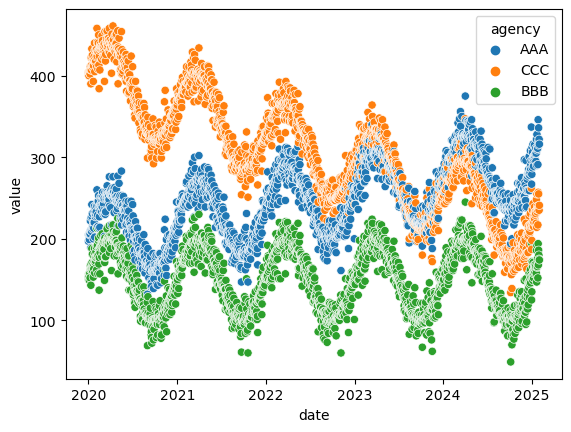

In [5]:
sns.scatterplot(data=df, x='date', y='value', hue='agency')

<Axes: xlabel='date', ylabel='value'>

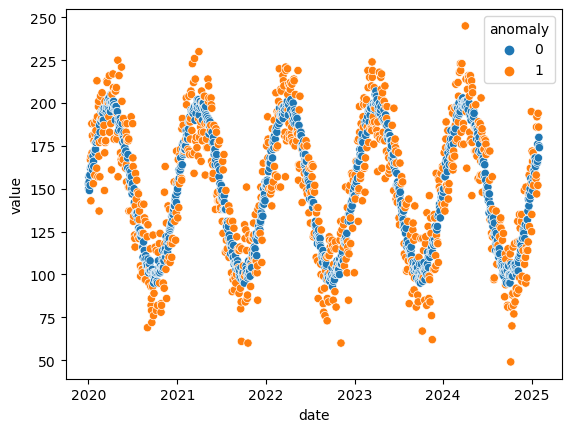

In [6]:
sns.scatterplot(data=df.query("agency=='BBB'"), x='date', y='value', hue='anomaly')

EDA

In [7]:
anomaly_counts = df['anomaly'].value_counts()
print("\nClass Dstribution:\n")
print(anomaly_counts)


Class Dstribution:

anomaly
0    3045
1    2529
Name: count, dtype: int64


In [8]:
df['date']

0      2020-01-01
1      2020-01-01
2      2020-01-01
3      2020-01-02
4      2020-01-02
          ...    
5569   2025-01-30
5570   2025-01-30
5571   2025-01-31
5572   2025-01-31
5573   2025-01-31
Name: date, Length: 5574, dtype: datetime64[ns]

In [9]:
df.set_index('date', inplace=True)

In [10]:
df = df.sort_index()

In [11]:
df.head()

,value,agency,anomaly
date,,,
2020-01-01,197,AAA,0
2020-01-01,404,CCC,0
2020-01-01,153,BBB,0
2020-01-02,205,AAA,0
2020-01-02,401,CCC,0


In [12]:
df.isnull().sum()

value      0
agency     0
anomaly    0
dtype: int64

we focused on detecting anomalies in time-series data provided by multiple agencies. Each record in the dataset contains a date, a numeric value, an agency name (such as AAA, BBB, or CCC), and a label indicating whether the data point is normal (0) or an anomaly (1). Anomalies can represent real-world problems such as data corruption, unusual events, system failures, or fraud. Our goal was to build a model that can learn from historical data and accurately detect future anomalies in unseen time periods.

We began by loading and exploring the dataset. After converting the date column to proper datetime format, we inspected the first few rows, checked for missing values, and explored the class distribution. We found that anomalies were not extremely rare, but still underrepresented compared to normal data. We then visualized the data to better understand trends and behaviors. Using scatter plots, we explored how values changed over time for each agency, and where anomalies appeared. These visualizations helped us confirm that many anomalies coincided with large spikes or dips in the value, suggesting that the anomaly labels were meaningful.

Feature Engineering

In [13]:

# Extract time-based features using the index
df['month'] = df.index.month
df['quarter'] = df.index.quarter
df['year'] = df.index.year
df['day_of_year'] = df.index.dayofyear
df['day_of_week'] = df.index.dayofweek
df['is_weekend'] = (df.index.dayofweek >= 5).astype(int)

# Compute rolling window statistics (for each agency)
df.sort_values(by=["agency", "date"], inplace=True)  # 'date' now part of index, still needed for sorting
df["rolling_mean_7"] = df.groupby("agency")["value"].transform(lambda x: x.rolling(7, min_periods=1).mean())
df["rolling_std_7"] = df.groupby("agency")["value"].transform(lambda x: x.rolling(7, min_periods=1).std())
df["rolling_mean_30"] = df.groupby("agency")["value"].transform(lambda x: x.rolling(30, min_periods=1).mean())
df["rolling_mean_365"] = df.groupby("agency")["value"].transform(lambda x: x.rolling(365, min_periods=1).mean())

#lagged values
df['val_lag1']=df['value'].shift(1)
df['val_lag2']=df['value'].shift(2)
df['val_lag3']=df['value'].shift(3)

df["diff_1"] = df["value"] - df["val_lag1"]
df["diff_7"] = df["value"] - df["rolling_mean_7"]
df["diff_30"] = df["value"] - df["rolling_mean_30"]

# Encode categorical variable
df["agency_encoded"] = df["agency"].astype("category").cat.codes

# Display the updated dataset
df.head()


,value,agency,anomaly,month,quarter,year,day_of_year,day_of_week,is_weekend,rolling_mean_7,rolling_std_7,rolling_mean_30,rolling_mean_365,val_lag1,val_lag2,val_lag3,diff_1,diff_7,diff_30,agency_encoded
date,,,,,,,,,,,,,,,,,,,,
2020-01-01,197,AAA,0,1,1,2020,1,2,0,197.000000,NaN,197.000000,197.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,0
2020-01-02,205,AAA,0,1,1,2020,2,3,0,201.000000,5.656854,201.000000,201.000000,197.0,NaN,NaN,8.0,4.000000,4.000000,0
2020-01-03,205,AAA,0,1,1,2020,3,4,0,202.333333,4.618802,202.333333,202.333333,205.0,197.0,NaN,0.0,2.666667,2.666667,0
2020-01-04,200,AAA,0,1,1,2020,4,5,1,201.750000,3.947573,201.750000,201.750000,205.0,205.0,197.0,-5.0,-1.750000,-1.750000,0
2020-01-05,199,AAA,0,1,1,2020,5,6,1,201.200000,3.633180,201.200000,201.200000,200.0,205.0,205.0,-1.0,-2.200000,-2.200000,0


To help our model understand patterns in the data, we performed extensive feature engineering. We extracted time-based features such as month, quarter, day of year, day of week, and whether the date fell on a weekend. We also created rolling window features like 7-day and 30-day averages and standard deviations, which help capture seasonality and volatility. In addition, we added lag features that captured the value from previous days (lag 1, lag 2, lag 3), and difference features that measured how much today's value deviates from the recent rolling mean or previous values. These features gave the model rich context to learn from

Using XGBoost Model for Anomaly Detection as it is a Supervised Data 

In [14]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Properly select multiple columns using a list
X = df[[
    "value", "year", "month", "day_of_week", "rolling_mean_30",
    "day_of_year", "rolling_mean_7", "rolling_std_7","diff_1","diff_7","diff_30",
    "rolling_mean_365", "val_lag1", "val_lag2", "val_lag3"
]]

y = df["anomaly"]

# Split data

# 80% train, 20% test in the sequence of the sorted time index 
split_index = int(len(df) * 0.8)
X_train = X.iloc[:split_index]
X_test = X.iloc[split_index:]
y_train = y.iloc[:split_index]
y_test = y.iloc[split_index:]

# Train XGBoost model
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
m = XGBClassifier(scale_pos_weight=scale_pos_weight)
m.fit(X_train, y_train)

# Predict
y_pred = m.predict(X_test)

# Evaluate
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Output results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")


Accuracy: 0.9148
Precision: 0.9350
Recall: 0.8745
F1-score: 0.9037


Instead of randomly splitting the data, we applied a time-based train/test split. This means we used the first 80% of the timeline for training, and the last 20% for testing. This approach mimics how anomaly detection works in the real world — learning from the past to predict future behavior. It also prevents data leakage and makes our evaluation more realistic.We chose to use XGBoost, a powerful tree-based machine learning model known for its speed and accuracy. Since anomalies are a minority class, we handled class imbalance by adjusting the scale_pos_weight parameter in the model. This tells XGBoost to give more weight to the anomaly class during training. After training, we used GridSearchCV to tune hyperparameters like max depth, learning rate, number of trees, and subsampling ratios. This helped us find the best combination of settings for the most accurate results.The performance of our final model was excellent.Precision tells us that when our model predicts an anomaly, it’s usually correct. Recall tells us that we were able to detect most of the true anomalies. The F1-score balances both precision and recall, and is especially useful in imbalanced classification problems like this one. Overall, the model performed well at identifying anomalies without over-predicting.

Checking the importance of the Features

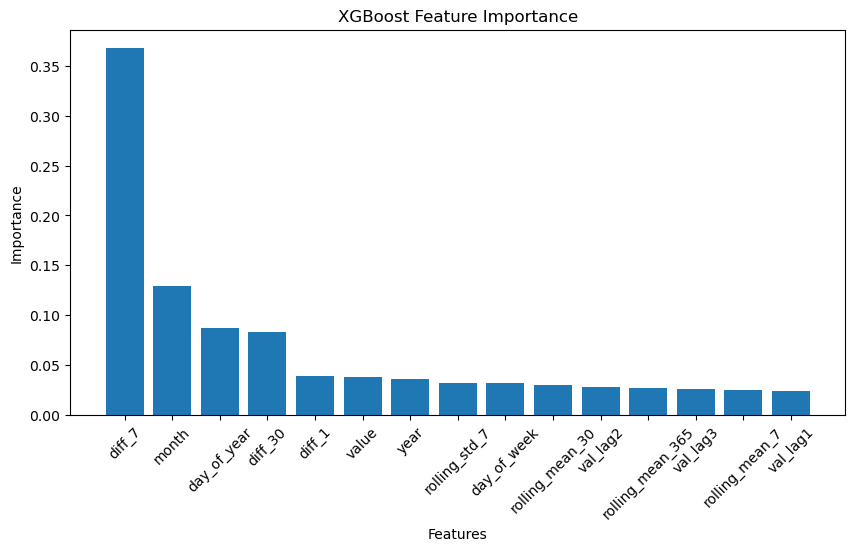

In [15]:
import matplotlib.pyplot as plt
import numpy as np
# Feature Importance Visualization
# Get feature importance
importance = m.feature_importances_
feature_names = X.columns

# Plot feature importance
plt.figure(figsize=(10, 5))
indices = np.argsort(importance)[::-1]  # Sort in descending order
plt.bar(range(len(importance)), importance[indices], align="center")
plt.xticks(range(len(importance)), feature_names[indices], rotation=45)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("XGBoost Feature Importance")
plt.show()


Confusion Matrix 

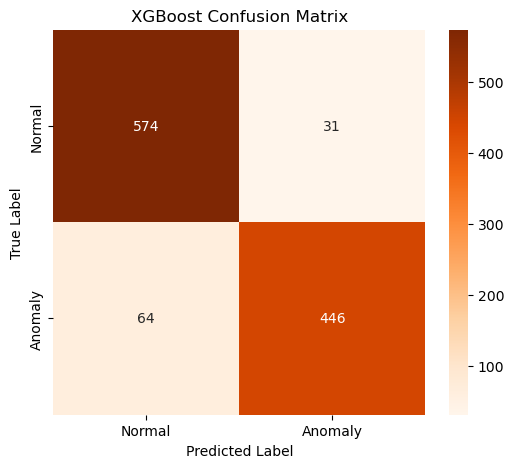

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
# Confusion Matrix Visualization
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("XGBoost Confusion Matrix")
plt.show()


To understand how the model made its decisions, we plotted the feature importance chart. It showed that the most helpful features were lag values and difference metrics like diff_7, val_lag1, and rolling means. These features helped the model spot sudden deviations from normal patterns. We also used a confusion matrix to analyze how many anomalies were correctly and incorrectly classified, and visualized predicted vs. actual anomalies over time to confirm the model’s behavior aligned with real events.

Doing Cross Validation

In [17]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(m, X, y, cv=5)
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV score: {cv_scores.mean()}")


Cross-validation scores: [0.89865471 0.92376682 0.88520179 0.91390135 0.91113106]
Mean CV score: 0.906531144584618


### The mean CV score of 0.9065 suggests that the model has strong generalization ability. Overall, the model appears to perform well with a relatively stable performance across different splits.

Plotting Roc Curve 

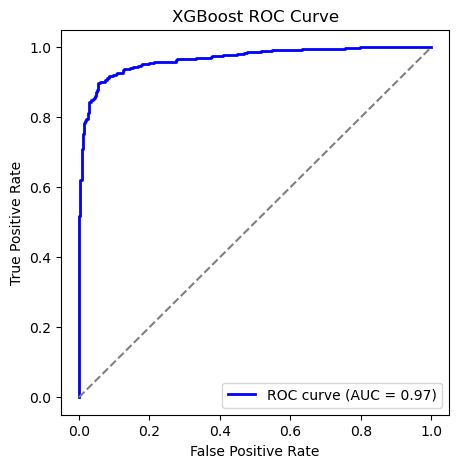

AUC Score: 0.9672


In [18]:
from sklearn.metrics import roc_curve, auc
# ROC Curve & AUC Score
# Predict probabilities
y_proba = m.predict_proba(X_test)[:, 1]  # Get the probability of the positive class

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')  
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("XGBoost ROC Curve")
plt.legend(loc="lower right")
plt.show()

# Compute AUC
roc_auc = auc(fpr, tpr)

print(f"AUC Score: {roc_auc:.4f}")

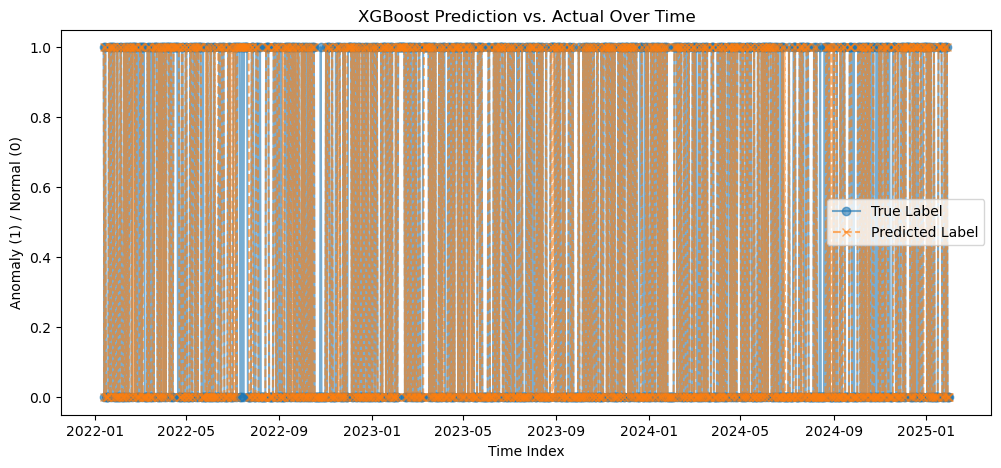

In [19]:
# Predicted vs. Actual Overall Time Series dataset Visualization 
df_results = X_test.copy()
df_results['True Label'] = y_test.values
df_results['Predicted Label'] = y_pred

# Plot time series
plt.figure(figsize=(12, 5))
plt.plot(df_results.index, df_results['True Label'], label="True Label", marker="o", linestyle="-", alpha=0.6)
plt.plot(df_results.index, df_results['Predicted Label'], label="Predicted Label", marker="x", linestyle="--", alpha=0.6)
plt.xlabel("Time Index")
plt.ylabel("Anomaly (1) / Normal (0)")
plt.title("XGBoost Prediction vs. Actual Over Time")
plt.legend()
plt.show()

Plotting Anomalies for Agency AAA

Text(0.5, 1.0, 'True vs Predicted Anomalies (AAA)')

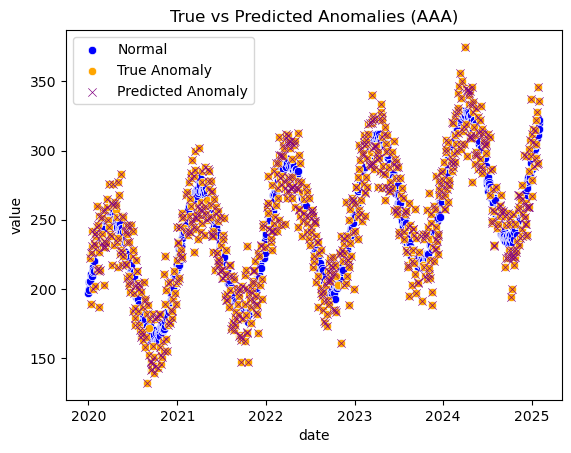

In [20]:
# Predicted vs. Actual for AAA agency
df_plot = df.query("agency=='AAA'").copy()
df_plot["predicted_anomaly"] = m.predict(df_plot[[
    "value", "year", "month", "day_of_week", "rolling_mean_30",
    "day_of_year", "rolling_mean_7", "rolling_std_7","diff_1","diff_7","diff_30",
    "rolling_mean_365", "val_lag1", "val_lag2", "val_lag3"
]])

# Plot normal data points (non-anomalies)
sns.scatterplot(data=df_plot[df_plot['anomaly'] == 0], x='date', y='value', color='blue', label='Normal')

# Plot true anomalies
sns.scatterplot(data=df_plot[df_plot['anomaly'] == 1], x='date', y='value', color='orange', label='True Anomaly', marker='o')

# Plot predicted anomalies
sns.scatterplot(data=df_plot[df_plot['predicted_anomaly'] == 1], x='date', y='value', color='purple', label='Predicted Anomaly', marker='x')

# Labels and legend
plt.title("True vs Predicted Anomalies (AAA)")

Plotting Anomolies for Agency BBB

Text(0.5, 1.0, 'True vs Predicted Anomalies (BBB)')

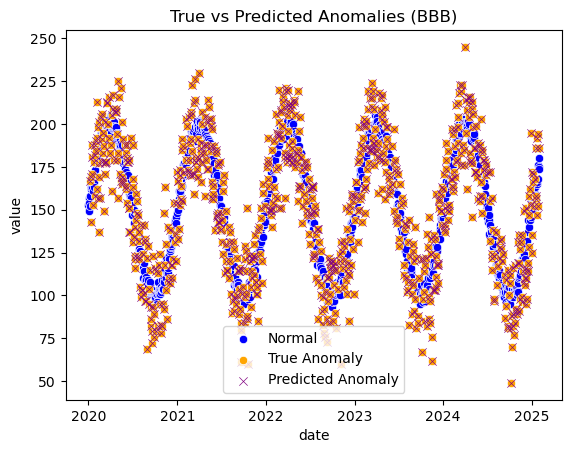

In [21]:
# Predicted vs. Actual for BBB agency
df_plot = df.query("agency=='BBB'").copy()
df_plot["predicted_anomaly"] = m.predict(df_plot[[
    "value", "year", "month", "day_of_week", "rolling_mean_30",
    "day_of_year", "rolling_mean_7", "rolling_std_7","diff_1","diff_7","diff_30",
    "rolling_mean_365", "val_lag1", "val_lag2", "val_lag3"
]])

# Plot normal data points (non-anomalies)
sns.scatterplot(data=df_plot[df_plot['anomaly'] == 0], x='date', y='value', color='blue', label='Normal')

# Plot true anomalies
sns.scatterplot(data=df_plot[df_plot['anomaly'] == 1], x='date', y='value', color='orange', label='True Anomaly', marker='o')

# Plot predicted anomalies
sns.scatterplot(data=df_plot[df_plot['predicted_anomaly'] == 1], x='date', y='value', color='purple', label='Predicted Anomaly', marker='x')

# Labels and legend
plt.title("True vs Predicted Anomalies (BBB)")


Plotting Anomalies for agency CCC

Text(0.5, 1.0, 'True vs Predicted Anomalies (CCC)')

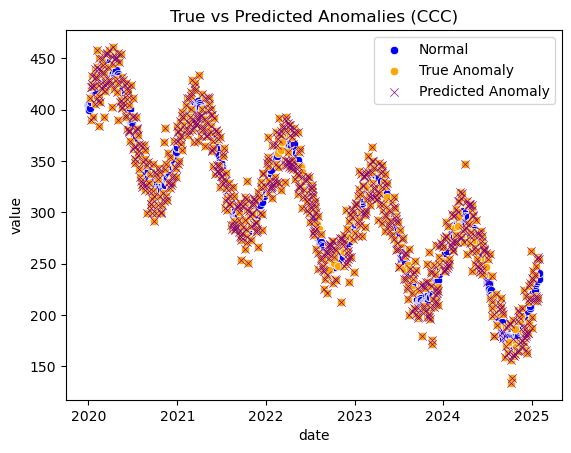

In [22]:
# Predicted vs. Actual for CCC agency
df_plot = df.query("agency=='CCC'").copy()
df_plot["predicted_anomaly"] = m.predict(df_plot[[
    "value", "year", "month", "day_of_week", "rolling_mean_30",
    "day_of_year", "rolling_mean_7", "rolling_std_7","diff_1","diff_7","diff_30",
    "rolling_mean_365", "val_lag1", "val_lag2", "val_lag3"
]])

# Plot normal data points (non-anomalies)
sns.scatterplot(data=df_plot[df_plot['anomaly'] == 0], x='date', y='value', color='blue', label='Normal')

# Plot true anomalies
sns.scatterplot(data=df_plot[df_plot['anomaly'] == 1], x='date', y='value', color='orange', label='True Anomaly', marker='o')

# Plot predicted anomalies
sns.scatterplot(data=df_plot[df_plot['predicted_anomaly'] == 1], x='date', y='value', color='purple', label='Predicted Anomaly', marker='x')

# Labels and legend
plt.title("True vs Predicted Anomalies (CCC)")

In [24]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_train = y_train.values.ravel() if hasattr(y_train, 'values') else y_train

# Define hyperparameter search space
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

# Initialize XGBoost using CPU (tree_method='hist')
xgb = XGBClassifier(
    eval_metric='logloss',
    random_state=42,
    tree_method='hist'  
)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    error_score='raise'  
)

# Fit the model
grid_search.fit(X_train, y_train)

# Output the best hyperparameters
print(f"Best parameters: {grid_search.best_params_}")

# Predict using the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print evaluation results
print(f"Optimized Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

Best parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.9}
Optimized Accuracy: 0.9139
Precision: 0.9367
Recall: 0.8706
F1-score: 0.9024


Finally, we evaluated how the model performed for each agency individually. We created separate scatter plots for AAA, BBB, and CCC, comparing predicted and actual anomalies. This helped us ensure that the model didn’t favor one agency over another and could detect patterns in different time series equally well.

In conclusion, we successfully built and evaluated a time-aware, anomaly detection model using XGBoost. We applied careful preprocessing, engineered meaningful features, handled class imbalance, tuned the model with cross-validation, and validated performance using multiple metrics and visualizations. This project demonstrates how machine learning can be applied to real-world time series data to detect unusual behavior early and accurately.